# AdaDelta

 * [ADADELTA: An Adaptive Learning Rate Method](https://arxiv.org/abs/1212.5701)

### Abstract

AdaDelta는 per-dimension learning rate method를 갖고있으며,
첫번째     Vanilla stochastic gradient descent보다

### Gradient Descent 의 문제.. 

많은 머신러닝 알고리즘들은 a set of parameters $ \theta $ 값을 objective function $ f(\theta) $를 optimize함으로서 update해줍니다.<br>
이러한 알고리즘들은 보통 iterative procedure를 갖고 있으며, 매 iteration마다  change to the parameters인 $ \Delta \theta $를 적용시킵니다. 

$$ \theta_{t+1} = \theta_t + \Delta \theta_t $$

이때 negative gradient $ g_t $를 사용합니다. 즉..

$$ \Delta \theta_t = - \eta g_t $$

여기서 $ g_t $는 partial derivative이고, $ \eta $는 learning rate를 가르킵니다.

$$ g_t = \frac{\partial f(\theta_t)}{\partial \theta_t} $$

보통 SGD 또는 Mini-batch GD를 사용하게 되는데.. 문제는 learning rate를 명시해야 하며, learning rate에 따라서 결과값이 크게 영향받을수 있습니다.<br>
즉 learning rate를 크게 잡으면 diverge 되거나 낮게 잡으면 learning이 매우 느려지게 됩니다. <br>
따라서 Model에 대한 learning rate를 제대로 잡아야 하는데... 문제는 이게 사람이 잡는다는것이 문제. 

# Per-dimension First Order Methods 

### Momentum

가장 중요한 핵심은 gradient $ g_t $ 지속적으로 같은 방향을 가르키며, gradient의 부호(sign...- 또는 +)가 지속적으로 변한다면.. progress를 slow시키는 것입니다. <br>
이는 past parameter update $ \Delta \theta_{t-1} $, 그리고 exponential decay $ \gamma $를 사용함으로서 가능해집니다.

$$ \Delta \theta_t = \gamma \Delta \theta_{t-1} - \eta g_t $$

여기서 $ \gamma $는 constant값으로서 이전 parameter update $ \Delta \theta_{t-1} $을 control 합니다.<br>

SGD에서 progress는 매우 느립니다. 왜냐하면 gradient magnitude은 매우 작으며, <br>
fixed global learning rate (게다가 모든 dimensions에 적용) progress를 더더욱 느리게 만들어버립니다.

높은 learning rate를 사용하면 valley를 서로 왔다갔다하는 oscillations을 만들수도 있습니다.

### AdaGrad

update rule은 다음과 같습니다. 

$$ \Delta \theta_t = - \frac{\eta}{\epsilon + \sqrt{ \sum^t_{τ=1} g^2_τ }} \odot g_t $$

여기서 denominator의 경우 l2 norm 의 모든 이전의 gradients를 연산합니다. <br>
$ \eta $의 경우 global learning rate입니다.

물론 global learning rate가 있지만, 각각의 $ \theta $의 dimension마다 각각의 dynamic rate를 갖고 있습니다. <br>
dynamic rate는 gradient magnitude와 반대로 커나가기 때문에, large gradient의 경우 작은 learning rate갖으며, small gradient의 경우에는 large learning rate를 갖습니다. 

# Second Order Methods

## AdaDelta

먼저 AdaGrad의 문제점은 다음과 같습니다. 

1. Training동안 지속적으로 작아지는 learning rate (continual decay of learning rates throughout training)
2. Global Learning Rate의 선택 필요 

### exponentially decaying average of the squared gradients
sum of squared gradients를 accumulate하는 것이 아니라, AdaDelta는 window of accumulated past gradients를 제한함으로서 고정된 싸이즈의 w값을 유지합니다. 이전의 squared gradients값 w를 저장하는것은 비효율적이기 때문에, accumulation은 exponentially decaying average of the squared gradients로 구현을 합니다.

[원문] Since storing $ w $ previous squared gradients is inefficient, our methods implements this accumulation as an exponentially decaying average of the squared gradients. Assume at
time t this running average is $ E[g^2]_t $ then we compute

$$ E[g^2]_t = \gamma E[g^2]_{t-1} + (1-\gamma)g^2_t $$

여기서 $ \gamma $는 Momentum method에서 사용된 것과 유사한 decay constant입니다.<br>
update시에 square root을 해줘야 하며, 궁극적으로 이전 squared gradients (t시간 까지의)의 RMS가 됩니다. 

$$ RMS[g]_t = \sqrt{E[g^2]_t + \epsilon} $$

* [RMS참고 - Wolfram MathWorld](http://mathworld.wolfram.com/Root-Mean-Square.html)

궁극적으로 Denominator는 $ RMS[g]_t $로 대체 될수 있습니다.

$$ \Delta \theta_t =  \frac{\eta}{RMS[g]_t} \odot g_t $$

### Exponentially decaying average of the squared weights
위의 공식 분모에서 mean squared gradient를 구했습니다.<br>
이때 분자에서도 동일한 units으로 계산이 되어야 합니다. 따라서 mean squared weight 를 구합니다.

$$ E[\Delta \theta^2]_t = \gamma E[\Delta \theta^2]_{t-1} + (1-\gamma) \Delta \theta^2_t  $$

위의 root mean squared error of weight updates는 다음과 같습니다.

$$ RMS[\Delta \theta]_t = \sqrt{E[\Delta \theta^2]_t + \epsilon} $$

일단 $ E[\Delta \theta^2]_t $는 모르는 상태이기 때문에, 이전 update rule인 $ E[\Delta \theta]_{t-1} $로 approximate해주면 AdaDelta 공식이 나오게 됩니다.<br>

$$ \begin{align} 
\Delta \theta_t &= - \frac{RMS[\Delta \theta]_{t-1}}{RMS[g]_t} \odot g_t  \\
\theta_{t+1} &= \theta_t + \Delta \theta_t
\end{align}
$$

### Algorithm

* **Require**: Decay Rate $ \gamma $, Epsilon Constant $ \epsilon $
* **Initialization**: $ \theta 초기화 $, accumulation variables $ E[g^2]_0 = 0 $, $ E[\Delta \theta^2]_0 = 0 $


1. for t = 1: T do: <br>
  1. Compute Gradient: $ g_t$
  2. Accumulate Gradient: $$ E[g^2]_t = \gamma E[g^2]_{t-1} + (1-\gamma)g^2_t $$
  3. Compute Update: $$ \Delta \theta_t = - \frac{RMS[\Delta \theta]_{t-1}}{RMS[g]_t} \odot g_t $$
  4. Accumulate Updates:  $$ E[\Delta \theta^2]_t = \gamma E[\Delta \theta^2]_{t-1} + (1-\gamma)\Delta \theta^2_t $$
  5. Apply Update: $$ \theta_{t + 1} = \theta_t + \Delta \theta_t $$

# Implementation

### Import

In [1]:
%pylab inline
import numpy as np
import pandas as pd

from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris

Populating the interactive namespace from numpy and matplotlib


### Data

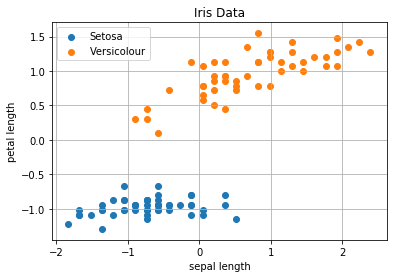

In [2]:
iris = load_iris()

# setosa_x = iris.data[:50]
# setosa_y = iris.target[:50]
# versicolor_x = iris.data[50:100]
# versicolor_y = iris.target[50:100]
# scatter(setosa_x[:, 0], setosa_x[:, 2])
# scatter(versicolor_x[:, 0], versicolor_x[:, 2])

# Extract sepal length, petal length from Setosa and Versicolor
data = iris.data[:100, [0, 2]]

# Standardization
scaler = StandardScaler()
data = scaler.fit_transform(data)


# Split data to test and train data
train_x, test_x, train_y, test_y = train_test_split(data, iris.target[:100], test_size=0.3)

# Plotting data
scatter(data[:50, 0], data[:50, 1], label='Setosa')
scatter(data[50:100, 0], data[50:100, 1], label='Versicolour')
title('Iris Data')
xlabel('sepal length')
ylabel('petal length')
grid()
legend()

### SGD with AdaDelta Optimizer

In [7]:
w =   np.array([ 0.09370901, -0.24480254, -0.84210235]) # np.random.randn(2 + 1)

def predict(w, x):
    N = len(x)
    yhat = w[1:].dot(x.T) + w[0]
    return yhat

def  adadelta_nn(w, X, Y, decay=0.2, epoch=4, weight_size=2):
    """
    @param eta <float>: learning rate
    """
    N = len(X)
    e = 1e-8
    
    Eg = np.zeros(weight_size + 1)  # E[g^2]
    Ed = np.zeros(weight_size + 1)  # E[\Delta w^2]
        
    i = 0
    for _ in range(epoch):
        for _ in range(N):
            x = X[i]
            y = Y[i]
            x = x.reshape((-1, 2))
            yhat = predict(w, x)

            # Calculate the gradients
            gradient_w = 2/N*-(y-yhat).dot(x)
            gradient_b = 2/N*-(y-yhat)

            # Accumulate Gradient
            Eg[1:] = decay * Eg[1:] + (1-decay) * gradient_w**2
            Eg[0]  = decay * Eg[0] + (1-decay) * gradient_b**2

            # Compute Update
            delta_w = - np.sqrt(e + Ed[1:])/np.sqrt(e + Eg[1:]) * gradient_w
            delta_b = - np.sqrt(e + Ed[0])/np.sqrt(e + Eg[0]) * gradient_b

            # Accumulate Updates
            Ed[1:] = decay * Ed[1:] + (1-decay) * delta_w**2
            Ed[0]  = decay * Ed[0]  + (1-decay) * delta_b**2

            w[1:] = w[1:] + delta_w
            w[0] = w[0] + delta_b

            i += 1
            if i >= N:
                i = 0
           
    return w


for i in range(45):
    w = adadelta_nn(w, train_x, train_y)

    # Accuracy Test
    yhats = predict(w, test_x)
    yhats = np.where(yhats >= 0.5, 1, 0)
    accuracy = round(accuracy_score(test_y, yhats), 2)
    print(f'[{i:2}] Accuracy: {accuracy:<4.2}')

[ 0] Accuracy: 0.0 
[ 1] Accuracy: 0.0 
[ 2] Accuracy: 0.0 
[ 3] Accuracy: 0.0 
[ 4] Accuracy: 0.0 
[ 5] Accuracy: 0.0 
[ 6] Accuracy: 0.07
[ 7] Accuracy: 0.43
[ 8] Accuracy: 0.5 
[ 9] Accuracy: 0.5 
[10] Accuracy: 0.5 
[11] Accuracy: 0.5 
[12] Accuracy: 0.5 
[13] Accuracy: 0.57
[14] Accuracy: 0.67
[15] Accuracy: 0.7 
[16] Accuracy: 0.73
[17] Accuracy: 0.83
[18] Accuracy: 0.83
[19] Accuracy: 0.9 
[20] Accuracy: 0.93
[21] Accuracy: 0.97
[22] Accuracy: 0.97
[23] Accuracy: 0.97
[24] Accuracy: 0.97
[25] Accuracy: 0.97
[26] Accuracy: 0.97
[27] Accuracy: 0.97
[28] Accuracy: 0.97
[29] Accuracy: 0.97
[30] Accuracy: 0.97
[31] Accuracy: 0.97
[32] Accuracy: 0.97
[33] Accuracy: 0.97
[34] Accuracy: 0.97
[35] Accuracy: 0.97
[36] Accuracy: 0.97
[37] Accuracy: 0.97
[38] Accuracy: 0.97
[39] Accuracy: 0.97
[40] Accuracy: 1.0 
[41] Accuracy: 1.0 
[42] Accuracy: 1.0 
[43] Accuracy: 1.0 
[44] Accuracy: 1.0 
